# Image registration helper  

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In [ ]:
#hide 
import numpy as np 
import matplotlib.pyplot as plt 
import skimage.exposure as ske

from maxrf4u import DataStack 

In [ ]:
from maxrf4u import DataStack 

ds = DataStack('RP-T-1898-A-3689.datastack') 

x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)

is_iron_Ka_band = (x_keVs > 6.1) * (x_keVs < 6.7) 

FeKa_slice = cube[:,:,is_iron_Ka_band].compute() # load only this slice into memory 
FeKa_map = FeKa_slice.sum(axis=2) / 60 # number of channels in the Fe_Ka band 

In [ ]:
susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

im_src = susanna_highres
im_dst = FeKa_map 

# corner points for image registration 
#pts_src = np.array([[78.5, 204.6], [4340.1, 180.4], [4374.9, 4724.9], [110.1, 4766.3]])
#pts_dst = np.array([[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]])

#imvis_reg_highres, extent = warp(im_src, im_dst, pts_src, pts_dst, rgba=False)
#imvis_reg, extent = warp(im_src, im_dst, pts_src, pts_dst, keep_scale=False, rgba=False)

## One possibility is straight from matplotlib 

https://scipy-cookbook.readthedocs.io/items/Matplotlib_Drag_n_Drop_Text_Example.html

In [ ]:
from matplotlib import pylab as p
from matplotlib.text import Text

class DragHandler(object):
    """ A simple class to handle Drag n Drop.

    This is a simple example, which works for Text objects only
    """
    def __init__(self, figure=None) :
        """ Create a new drag handler and connect it to the figure's event system.
        If the figure handler is not given, the current figure is used instead
        """

        if figure is None : figure = p.gcf()
        # simple attibute to store the dragged text object
        self.dragged = None

        # Connect events and callbacks
        figure.canvas.mpl_connect("pick_event", self.on_pick_event)
        figure.canvas.mpl_connect("button_release_event", self.on_release_event)

    def on_pick_event(self, event):
        " Store which text object was picked and were the pick event occurs."

        if isinstance(event.artist, Text):
            self.dragged = event.artist
            self.pick_pos = (event.mouseevent.xdata, event.mouseevent.ydata)
        return True

    def on_release_event(self, event):
        " Update text position and redraw"

        if self.dragged is not None :
            old_pos = self.dragged.get_position()
            new_pos = (old_pos[0] + event.xdata - self.pick_pos[0],
                       old_pos[1] + event.ydata - self.pick_pos[1])
            self.dragged.set_position(new_pos)
            self.dragged = None
            p.draw()
        return True

<IPython.core.display.Javascript object>


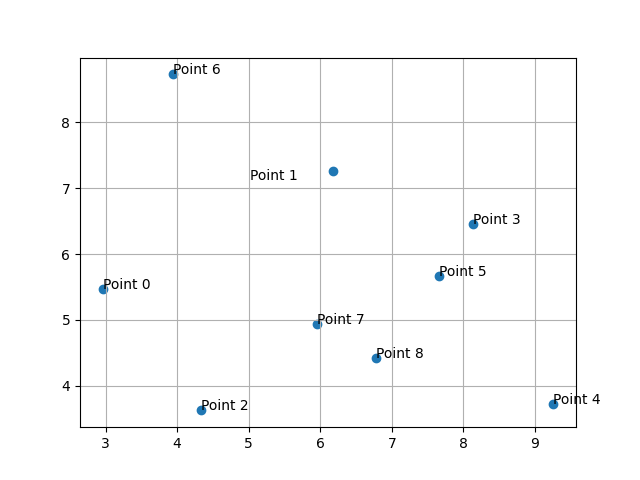

In [ ]:
# Usage example
from numpy import *

# Create arbitrary points and labels
x, y = random.normal(5, 2, size=(2, 9))
labels = [ "Point %d" % i for i in range(x.size)]

# trace a scatter plot
p.scatter(x, y)
p.grid()

# add labels and set their picker attribute to True
for a,b,l in zip(x,y, labels):
    p.text(a, b, l, picker=True)

# Create the event hendler 
dragh = DragHandler()

p.show()

## Or folium/ipyleaflet...

https://blog.ouseful.info/2019/04/02/fragment-components-for-rolling-your-own-gis-inside-jupyter-notebooks/

Should be possible to add a draggable marker: https://stackoverflow.com/questions/54052995/i-want-to-move-one-marker-to-another 



https://stackoverflow.com/questions/62538396/leaflet-folium-creating-a-fantasy-map-removing-the-world-map


    import folium

    def create_aldrune_map():
        base_map = folium.Map(crs='Simple', zoom_start=4, tiles=None)  # added tiles=None 

        aldrune_overlay = folium.raster_layers.ImageOverlay(
            image='Path/To/Image',
            bounds=[[0, 0], [1000, 1300]],
            zindex=1)
        aldrune_overlay.add_to(base_map)
        base_map.fit_bounds(bounds=[[0, 0], [1000, 1300]])

        base_map.save('Path/To/Output')

In [ ]:
import folium 
#from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl

#watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

#m = Map(layers=(watercolor, ), center=(50, 354), zoom=5, tiles=None)
#m = Map(center=(50, 354), zoom=5, tiles=None)

basemap  = folium.Map(crs='Simple', zoom_start=10, tiles=None)
basemap.fit_bounds(bounds=[[0, 0], [1000, 1000]])

primrose_overlay = folium.raster_layers.ImageOverlay(image='/home/frank/Work/ILLs/Primrose.jpg', 
                                                    bounds=[[0, 0], [1000, 1000]])
primrose_overlay.add_to(basemap)

#draw_control = DrawControl()

#m.add_control(draw_control)

basemap

https://stackoverflow.com/questions/54052995/i-want-to-move-one-marker-to-another

## Or bqplot

https://github.com/bqplot/bqplot/blob/master/examples/Introduction.ipynb

In [ ]:
from bqplot import pyplot as plt

In [ ]:
im = np.zeros([10, 10])
im[3:5, 6:8] = 1

In [ ]:
x_data = [1.0, 2.0, 4.0, 1.6] # make floats! 
y_data = [3.1, 1.0, 2.1, 6.2]

In [ ]:
def foo(change):
    #print("This is a trait change. Foo was called by the fact that we moved the Scatter")
    print(scatter_plot.y, end='\r')

In [ ]:
plt.figure(title="My First Plot")

#plt.imshow(im)
scatter_plot = plt.scatter(x_data, y_data)
scatter_plot.enable_move = True
scatter_plot.x = x_data
scatter_plot.y = y_data
scatter_plot.observe(foo, 'y')
plt.show()



In [ ]:
def foo(change):
    #print("This is a trait change. Foo was called by the fact that we moved the Scatter")
    print(scatter_plot.y, end='\r')
    

In [ ]:
scatter_plot.observe(foo, "y_data")

Now, I need to learn how to plot an image below. 